In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np; np.random.seed(0)
from extquadcontrol import ExtendedQuadratic, dp_infinite, dp_finite
import matplotlib.pyplot as plt
from plot_settings import savefig

from policy import TimeInvariantAffinePolicy
from system import InfiniteHorizonSystem

# Multi-mission LQR

In [3]:
n = 4
m = 2
N = 1
K = 3
T = 50

dt = .05
mass = 1
k = .4
targets = [
    np.array([-1,.5]),
    np.array([-1,-.25]),
    np.array([1,0])
]

mix = .97

Pi = np.array([
    [mix,.5*(1-mix)/2,(1-mix)/2],
    [.2*(1-mix)/2,mix,(1-mix)/2],
    [1.8*(1-mix)/2,1.5*(1-mix)/2,mix]
])

print (Pi)

As = np.r_[
    np.c_[np.eye(2),dt*np.eye(2)],
    np.c_[np.zeros((2,2)),(1.-1./mass*k*dt)*np.eye(2)]
]
Bs = np.r_[np.zeros((2,2)),dt/mass*np.eye(2)]
cs = np.zeros(4)

print (As)
print (Bs)

[[0.97   0.0075 0.015 ]
 [0.003  0.97   0.015 ]
 [0.027  0.0225 0.97  ]]
[[1.   0.   0.05 0.  ]
 [0.   1.   0.   0.05]
 [0.   0.   0.98 0.  ]
 [0.   0.   0.   0.98]]
[[0.   0.  ]
 [0.   0.  ]
 [0.05 0.  ]
 [0.   0.05]]


In [4]:
def get_sample(individual=False):
    def sample(N):
        A = np.zeros((N,K,n,n)); A[:] = As
        B = np.zeros((N,K,n,m)); B[:] = Bs
        c = np.zeros((N,K,n)); c[:] = cs

        Pi = np.array([
            [mix,.5*(1-mix)/2,(1-mix)/2],
            [.2*(1-mix)/2,mix,(1-mix)/2],
            [1.8*(1-mix)/2,1.5*(1-mix)/2,mix]
        ])
        if individual:
            Pi = np.eye(3)
        costs  = []
        for s in range(K):
            P = np.diag([1,1,0,0,.1,.1])
            q = np.zeros(n+m); q[:2] = -targets[s]
            r = targets[s]@targets[s]
            costs.append(ExtendedQuadratic(P,q,r))
        g = [costs for _ in range(N)]
        
        return A,B,c,g,Pi
    return sample

/home/shane/miniconda3/envs/gen_lqr/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


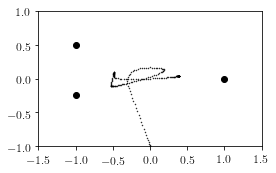

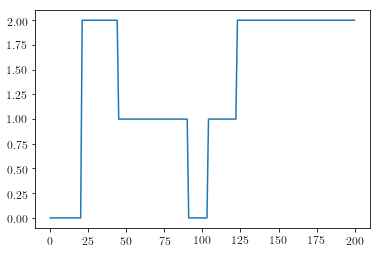

0.521979142026115


In [5]:
sample = get_sample()
Vs, Qs, policy = dp_infinite(sample, T, N)

policy = TimeInvariantAffinePolicy(policy)
system = InfiniteHorizonSystem(sample, K)

np.random.seed(15)
X, U, Modes, cost = system.simulate(np.array([0,-1,0,0]),0,200,policy)

fig = plt.figure()
plt.scatter(X[:,0],X[:,1],c='black',s=.2)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
for t in targets:
    plt.scatter(t[0],t[1],c='black')
savefig(fig, 'figs/multi1.pdf')
plt.show()
plt.close()

plt.plot(Modes)
plt.show()

print (cost)

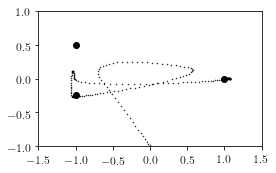

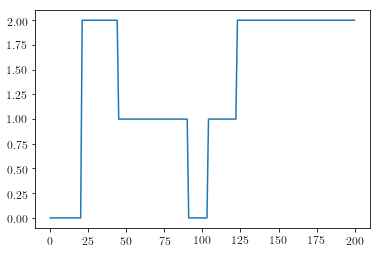

0.6547184817019318


In [6]:
sample = get_sample(individual=True)
Vs, Qs, policy = dp_infinite(sample, T, N)

policy = TimeInvariantAffinePolicy(policy)
system = InfiniteHorizonSystem(get_sample(individual=False), K)

np.random.seed(15)
X, U, Modes, cost = system.simulate(np.array([0,-1,0,0]),0,200,policy)

fig = plt.figure()
plt.scatter(X[:,0],X[:,1],c='black',s=.2)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
for t in targets:
    plt.scatter(t[0],t[1],c='black')
savefig(fig, 'figs/multi2.pdf')
plt.show()

plt.plot(Modes)
plt.show()

print (cost)